In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

In [8]:
sns.set_style("whitegrid")
print(f"TensorFlow Sürümü: {tf.__version__}")

TensorFlow Sürümü: 2.18.0


In [14]:
dataset, info = tfds.load(
    'oxford_iiit_pet:4.*.*',
    with_info=True,
    download_and_prepare_kwargs={'show_progress': False}
)

In [15]:
def load_and_preprocess(datapoint):
    # görüntüleri ve maskeleri yeniden boyutlandır
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    # nearest method
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')

    # fotoğrafın renklerini basitleştir - görüntü piksellerini [0, 1] aralığına normalize et
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # maske değerlerini [1, 2, 3] aralığından [0, 1, 2] aralığına çek
    input_mask -= 1

    # boyutlandırma işlemi sayıları ondalıklı yapabilir, sayılar tam sayı olsun
    input_mask = tf.cast(input_mask, tf.uint8)

    return input_image, input_mask

In [16]:
# train ve test veri setlerini tf.data pipeline ile hazırlama
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = dataset['train'].map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# 64'lü gruplar halinde batch, karışık sırada shuffle veriyoruz.
train_batches = (train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

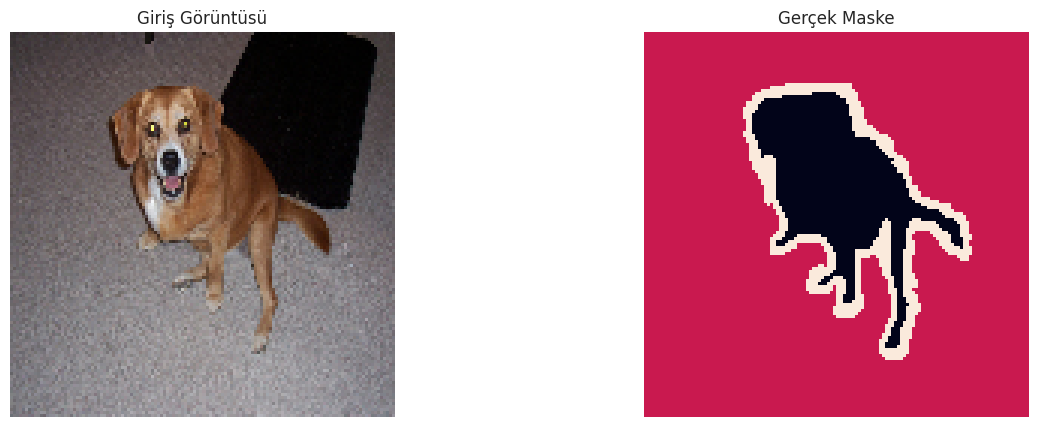

In [17]:
# görselleştirme
def display(display_list):
  plt.figure(figsize=(15, 5))
  title = ['Giriş Görüntüsü', 'Gerçek Maske', 'Tahmin Edilen Maske']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# tahmini, anlaşılır görsele dönüştürme
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# örnek
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

Transfer Learning ile U-Net Modeli Oluşturma

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# katman çıktıları
layer_names = [
    'block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
    'block_13_expand_relu', 'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

# decoder katmanları
up_stack = [
    layers.Conv2DTranspose(512, 3, strides=2, padding='same'),
    layers.Conv2DTranspose(256, 3, strides=2, padding='same'),
    layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
    layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same')  # 64x64 -> 128x128

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# modeli oluşturma
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


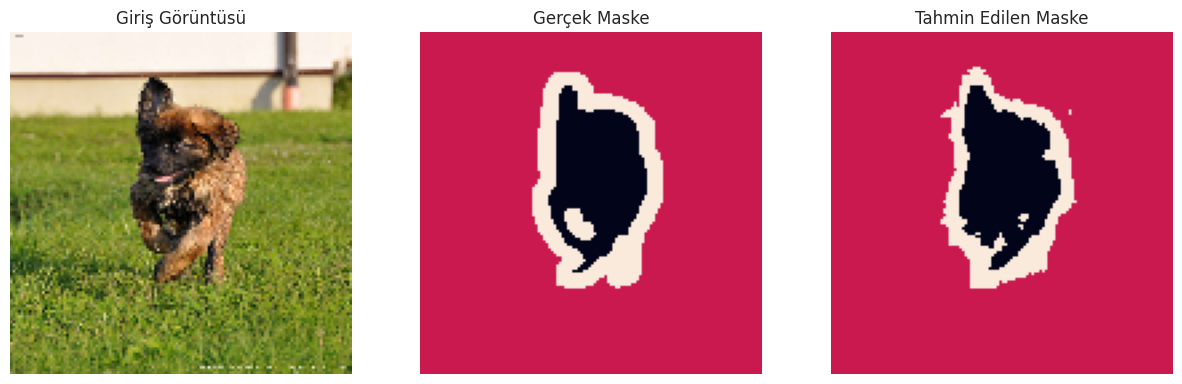


Epoch sonrası örnek tahmin gösteriliyor...

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.8958 - loss: 0.2702 - val_accuracy: 0.8858 - val_loss: 0.2987
Model eğitimi tamamlandı!


In [19]:
# interaktif eğitim & callback
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    for image, mask in test_batches.take(1):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
    print(f'\nEpoch sonrası örnek tahmin gösteriliyor...\n')

EPOCHS = 20

print(f"\nModel eğitimi {EPOCHS} epoch için başlatılıyor...")
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

print("Model eğitimi tamamlandı!")

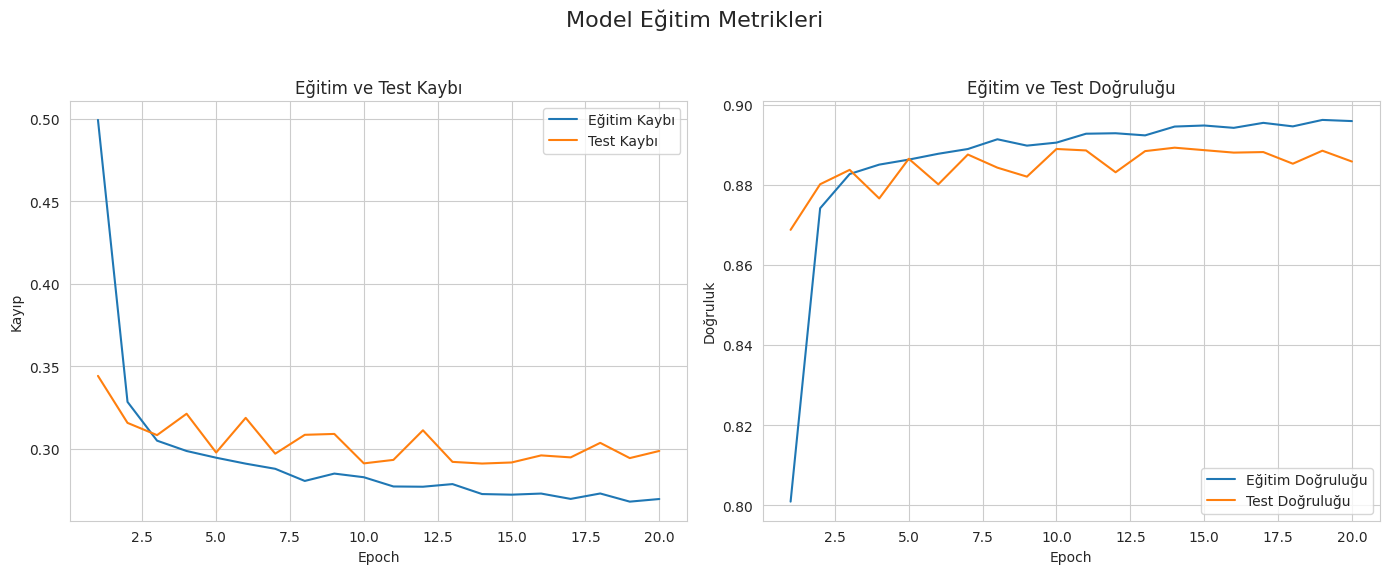

In [20]:
# eğitim sonuçları değerlendirme (seaborn & matplotlib)
history_df = pd.DataFrame(model_history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

# loss grafiği
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='epoch', y='loss', data=history_df, label='Eğitim Kaybı')
sns.lineplot(x='epoch', y='val_loss', data=history_df, label='Test Kaybı')
plt.title('Eğitim ve Test Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')

# accuracy grafiği
plt.subplot(1, 2, 2)
sns.lineplot(x='epoch', y='accuracy', data=history_df, label='Eğitim Doğruluğu')
sns.lineplot(x='epoch', y='val_accuracy', data=history_df, label='Test Doğruluğu')
plt.title('Eğitim ve Test Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')

plt.suptitle("Model Eğitim Metrikleri", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()